# **What Really Counts: A Cash Recognization System**

---

**Group Members**:
- Ek Chin Hui (A0205578X)
- Lee Hyung Woon (A0218475X)
- Toh Hai Jie Joey (A0205141Y)

---

Our project, named **What Really Counts**, is a Cash Recognization System for the Visually Impaired in Singapore. In Singapore, the disabled community face many challenges in their daily lives, and this is especially so for those who are hampered by visual impairments. One such challenge they face is cash payment, as they need to identify the correct combinations of bills and coins. As such, we embarked on a mission to construct a system that can help them overcome these challenges by employing a deep learning-based Object Detection model using Convolutional Neural Networks (CNN) - in particular, the Faster R-CNN model. The model uses CNNs to perform image classification on the objects detected in a given input image, through which we can ascertain the exact number and type of bills / coins present in the image, allowing us to calculate and return the sum of the currency to the user.

Here are the steps we took for this project:

1. Data Collection
2. Data Preparation
3. Data Visualisation
4. Building the Model
5. Training the Model
6. Testing the Model
7. Evaluation

In [2]:
import torch
import torch.nn.functional as F
import os
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT
import json
import time
import utils
import math
import numpy as np
import numpy.random as npr

from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.ops import nms, RoIAlign
from PIL import Image
from glob import glob
from pathlib import Path

## **1. Data Collection**

In order to build a system that can detect bills and coins, we first needed a dataset of images containing Singapore currency. Hence, our group decided to manually create the dataset by taking pictures of different combinations of bills and coins on different backgrounds. In total, around 200~ images were taken. 

As an initial proof-of-concept, we decided to focus our model on the 7 most common types of Singapore currency used in our daily lives: \$10 bills, \$5 bills, \$2 bills, \$1 coins, 50¢ coins, 20¢ coins, and 10¢ coins. These correspond to our class labels as shown below: `('10c', '20c', '50c', '$1', '$2', '$5', '$10')`.

In [3]:
# Set class labels
coin_labels = ('10c', '20c', '50c', '$1', '$2', '$5', '$10')

label_index_dict = {k : v + 1 for v, k in enumerate(coin_labels)}
label_index_dict['background'] = 0
print(label_index_dict)

index_label_dict = {v + 1 : k for v, k in enumerate(coin_labels)}
index_label_dict[0] = 'background'
print(index_label_dict)

{'10c': 1, '20c': 2, '50c': 3, '$1': 4, '$2': 5, '$5': 6, '$10': 7, 'background': 0}
{1: '10c', 2: '20c', 3: '50c', 4: '$1', 5: '$2', 6: '$5', 7: '$10', 0: 'background'}


After gathering the data, the images were manually labelled one-by-one using [LabelImg](https://github.com/tzutalin/labelImg), which allowed us to label the bounding boxes and their respective classes easily. LabelImg also had a feature to produce an XML file for each image with the bounding boxes and class information, which made it much more straightforward for us to deal with the data.

We then defined the `parse_annotation` function to parse the XML files into an object, as shown below.

In [4]:
def parse_annotation(annotation_path):
    '''
    Converts the XML data of a single image into an object.

    :param annotation_path: The file path of the XML file
    :return: An object (Python dictionary) with the bounding box parameters, and the corresponding labels for each bounding box
    '''

    # Parse the XML file into a tree structure
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    height = float(root.find('size').find('height').text)
    width = float(root.find('size').find('width').text)

    # Set initial lists
    boxes = list()
    labels = list()

    # Loop over each Bbox found in the XML file
    for object in root.iter('object'):

        # Convert Bbox co-ordinates
        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1
        boxes.append([xmin, ymin, xmax, ymax])

        # Convert Bbox Label
        label = object.find('name').text.lower().strip()
        if label not in label_index_dict:
            continue
        labels.append(label_index_dict[label])

    return {'boxes': boxes, 'labels': labels}

Next, we defined a function that makes use of the `parse_annotation` function to convert the XML files into JSON objects and store them within local JSON files. Here, each bounding box is stored as [xmin, ymin, xmax, ymax].
At the same time, the function also augments each image by randomly changing the brightness, contrast, saturation and hue. Each image is separately augmented 5 times.

In [11]:
def xml_to_json(*files):
    '''
    Converts an image (.jpg) and its corresponding XML file (.xml) into two separate local JSON objects.
    Augments each image to get 5 different augmentations per image.

    :param *files: All files in the specified directory, including images and corresponding XML files
    '''
    
    # Initialise lists
    images_list = [] 
    objects_list = []
    augment_images_list = [] 
    augment_objects_list = []
    files = [file for sublist in files for file in sublist]
    
    # Set up two JSON files to be written
    images_file = open("images.json", 'w')
    objects_file = open("objects.json", 'w')
    augment_images_file = open("dataset/augment_images.json", 'w')
    augment_objects_file = open("dataset/augment_objects.json", 'w')
    
    # Iterate through each XML-Image pair
    for file in files:
        file_path = os.path.splitext(file)[0]
        name = file_path.split('/')[1].split("dataset")[0]
        img_name = file_path.split('/')[1].split("dataset")[1][1:]
        img_file = file_path + ".jpg"

        # Add each image file path into the images list
        images_list.append(img_file)
        
        # Add each XML object into the objects list
        xml_dict = parse_annotation(file)
        objects_list.append(xml_dict)

        # Augment images
        image = Image.open(img_file, mode='r')
        image = image.convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        color_jitter = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.99, hue=0.5)

        for i in range(5):      
            augmented = (color_jitter)(image_tensor) 
            augmented = transforms.ToPILImage()(augmented)
            folder = 'dataset/' + name + "dataset/augmented"
            if not os.path.exists(folder):
                os.makedirs(folder)

            augmented_file = folder + '/' + img_name + str(i) + '.jpg'
            augmented = augmented.save(augmented_file)
            augment_images_list.append(augmented_file)
            augment_objects_list.append(xml_dict)
    
    # Write each list into the corresponding JSON files
    json.dump(images_list, images_file)
    json.dump(objects_list, objects_file)
    json.dump(augment_images_list, augment_images_file)
    json.dump(augment_objects_list, augment_objects_file)

Then, we converted our dataset from XML to JSON accordingly.

In [ ]:
CH_FILES = glob(r'dataset/ch dataset/*.xml')
xml_to_json(CH_FILES)

# JY_FILES = glob(r'dataset/jy dataset/*.xml')
# xml_to_json(JY_FILES)
# HW_FILES = glob(r'dataset/hw dataset/*.xml')
# xml_to_json(CH_FILES, HW_FILES)
# xml_to_json(HW_FILES)

## **2. Data Preparation**

With our raw data stored in local JSON files, we needed to further process the images into datasets for training and testing our system. The `DataLoader` and `Dataset` utils in PyTorch were used for organising our dataset.

First, we defined the `resize_and_normalise` function to resize and normalise the given images and the bounding boxes accordingly. This function was partially adapted from the [PyTorch Tutorial to Object Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py).

We set the default new image dimensions to `(320, 320)`, the standard input size that we used for our network.

In [214]:
def resize_and_normalise(image, boxes, dims = (320, 320)):
    '''
    Adapted from: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Resizes the input images and the bounding boxes, and applies Normalisations afterwards.
    
    :param image: The input image
    :param boxes: The coordinates of the bounding boxes in the image
    :param dims: The target dimensions of the resize
    :return: The transformed image and the transformed bounding box coordinates
    '''

    # Mean and Standard deviation used for the base VGG from torchvision
    # See: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Resize image and convert the image to Torch tensor
    new_image = FT.resize(image, dims)
    new_image = FT.to_tensor(new_image)
    
    # Normalize the image by mean and standard deviation
    new_image = FT.normalize(new_image, mean = mean, std = std)

    # Resize Bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
    new_boxes = (boxes / old_dims) * new_dims
    
    return new_image, new_boxes

Then, we declared a `WRCDataset` class which, as the name suggests, is simply a Dataset with the images that we collected (WRC standing for "What Really Counts"). This class was used to organise the data, and split them into the training dataset and the testing dataset.

In [215]:
class WRCDataset(Dataset):
    '''
    A PyTorch Dataset class to be used in a PyTorch DataLoader.
    '''
    
    def __init__(self, data_folder):
        '''
        Initialises the WRCDataset object.

        :param data_folder: The data folder path where the data files are stored
        '''

        # Set the data folder path
        self.data_folder = data_folder

        if data_folder == ".":
            # Read from the JSON files (initially craeted from our XML files)
            with open(os.path.join(data_folder, 'images.json'), 'r') as j:
                self.images = json.load(j)
            with open(os.path.join(data_folder, 'objects.json'), 'r') as j:
                self.objects = json.load(j)
        else:
            # Read from the JSON files (initially craeted from our XML files)
            with open(os.path.join(data_folder, 'augment_images.json'), 'r') as j:
                self.images = json.load(j)
            with open(os.path.join(data_folder, 'augment_objects.json'), 'r') as j:
                self.objects = json.load(j)

        # Number of images must match the number of objects containing the Bboxes for each image
        assert len(self.images) == len(self.objects)

    def __len__(self):
        '''
        Returns the number of data points in the WRCDataset.

        :return: The length of the WRCDataset
        '''

        return len(self.images)

    def __getitem__(self, i):
        '''
        Gets data from the WRCDataset with the given index.

        :param i: The index of the data to be returned
        :return: The specified data at the given index i
        '''

        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        image_tensor = transforms.Resize(size = (320, 320))(image_tensor)

        # Read objects in this image (Bboxes, labels)
        objects = self.objects[i]
        box = torch.FloatTensor(objects['boxes'])
        label = torch.LongTensor(objects['labels'])

        # Apply normalisations and resizes
        image, box = resize_and_normalise(image, box)
        box_and_label = torch.cat([box, label.unsqueeze(1)], 1)

        return image_tensor, box_and_label

    def collate_fn(self, batch):
        '''
        A collate function to be passed to the DataLoader, describing how to combine tensors of different sizes using Python lists.

        :param batch: An iterable set created from the __getitem__() function
        :return: A tensor of images and a list of tensor of bounding boxes
        '''

        images = list()
        boxes = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])

        images = torch.stack(images, dim = 0)
        return images, boxes

We organised the data using the WRCDataset class, and then split it into the training and testing datasets randomly with a ratio of 80:20. Afterwards, we loaded the training and testing datasets using the DataLoader util from PyTorch, which allowed us to iterate through the dataset with ease. 

We decided to stick to a batch size of 1 to achieve better training stability and generalization performance, as our dataset was relatively small.

In [ ]:
dataset = WRCDataset(".")
augmented_dataset = WRCDataset("dataset/")
train_data, test_data = torch.utils.data.random_split(dataset, [math.floor(0.8 * len(dataset)), math.ceil(0.2 * len(dataset))])
train_dataloader = DataLoader(ConcatDataset([train_data, augmented_dataset]), batch_size = 1, shuffle = True, collate_fn = dataset.collate_fn)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle = True, collate_fn = dataset.collate_fn)

## **3. Data Visualisation**

In order to ensure that the Data has been prepared properly, we used the `matplotlib` library to visualise the data in our dataset, and defined the `visualise_data` function.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math

color_maps = ['r', 'g', 'b', 'y', 'm', 'w', 'k', 'c']

# Visualise data
def visualise_data(dataloader):
    '''
    Visualises the first image and its corresponding bounding boxes using matplotlib.

    :param dataloader: The dataloader containing the dataset to be visualised
    '''
    
    for data in dataloader:
        for batch in range(1):
            img = data[0][batch]
            boxes = data[1][batch]
            plt.imshow(transforms.ToPILImage()(img))
            ax = plt.gca()
            labelled = set()
            for i, box in enumerate(boxes):
                w,h = box[2] - box[0], box[3] - box[1]
                x,y = box[0].item(), box[1].item()
                x = [x, x + w, x + w, x, x]
                y = [y, y, y + h, y + h, y]
                label = int(box[4].item())
                if label not in labelled:
                    plt.plot(x,y, color = color_maps[label], label = index_label_dict[label])
                    labelled.add(label)
                else:
                    plt.plot(x,y, color = color_maps[label])
                plt.legend(loc = 'best')
            break
        break

visualise_data(train_dataloader)

## **4. Building the Model**

Before building the actual network, we defined several utility functions that were used at various points throughout our network.

First, the `pascal_to_yolo` and the `yolo_to_pascal` functions helped us switch between the two data format as needed: the Pascal VOC data format and the YOLO data format.

In [10]:
def pascal_to_yolo(anchor):
    '''
    Transforms anchor coordinates of the form [xmin, ymin, xmax, ymax] to [x_center, y_center, width, height].

    :param anchor: The anchor to be transformed from Pascal VOC data format to YOLO data format
    :return: The anchor in the YOLO data format
    '''
    
    width = anchor[2] - anchor[0] + 1
    height = anchor[3] - anchor[1] + 1
    x_center = anchor[0] + (width - 1) / 2 
    y_center = anchor[1] + (height - 1) / 2
    return x_center, y_center, width, height

def yolo_to_pascal(x_center, y_center, width, height):
    '''
    Transforms anchor coordinates of the form [x_center, y_center, width, height] to [xmin, ymin, xmax, ymax].

    :param x_center: The x_center of the anchor in YOLO data format
    :param y_center: The y_center of the anchor in YOLO data format
    :param width: The width of the anchor in YOLO data format
    :param height: The height of the anchor in YOLO data format
    :return: The anchor in the Pascal VOC data format
    '''
    
    width = width[:, np.newaxis]
    height = height[:, np.newaxis]
    anchors = np.hstack((x_center - 0.5 * (width - 1), y_center - 0.5 * (height - 1), x_center + 0.5 * (width - 1), y_center + 0.5 * (height - 1)))
    return anchors

Using the `pascal_to_yolo` and the `yolo_to_pascal` functions, we defined the functions for generating the anchors.

The base anchor we used was `[0, 0, 15, 15]` in Pascal VOC data format (i.e. xmin = 0, ymin = 0, xmax = 15, ymax = 15).

In [11]:
def generate_ratio_anchors(anchor, ratios = np.array((0.5, 1, 2))):
    '''
    Generate anchors for each width:height ratio.

    :param anchor: The anchors to be resized
    :param ratios: The ratios to resize the anchors with
    :return: The resized anchors
    '''
    
    # Resize widths and heights
    x_center, y_center, width, height = pascal_to_yolo(anchor)
    size = width * height
    size_ratios = size / ratios
    resized_width = np.round(np.sqrt(size_ratios))
    resized_height = np.round(resized_width * ratios)
    
    # Return the resized anchors
    anchors = yolo_to_pascal(x_center, y_center, resized_width, resized_height)
    return anchors

def generate_scale_anchors(anchor, scales = np.array((8, 16, 32))):
    '''
    Generate anchors for each scale.

    :param anchor: The anchors to be rescaled
    :param ratios: The scales to rescale the anchors with
    :return: The rescaled anchors
    '''
    
    # Rescale widths and heights
    x_center, y_center, width, height = pascal_to_yolo(anchor) 
    scaled_width = width * scales
    scaled_height = height * scales

    # Return the rescaled anchors
    anchors = yolo_to_pascal(x_center, y_center, scaled_width, scaled_height)
    return anchors

def generate_anchors(height, width, aspect_ratio = np.array((0.5, 1, 2)), scales = np.array((8, 16, 32)), stride_length = 16):
    '''
    Generate anchors using the scales and the aspect ratios given.

    :param height: The height of the filter map to apply the anchors onto
    :param width: The width of the filter map to apply the anchors onto
    :param aspect_ratio: The aspect ratio for the anchors to be resized according to
    :param scales: The scales for the anchors to be rescaled according to
    :param stride_length: The stride of the anchors
    :return: The generated anchors from resizing and rescaling
    '''
    
    # Resize and Rescale the base anchor
    base_anchor = pascal_to_yolo([0, 0, 15, 15])
    ratio_anchors = generate_ratio_anchors(base_anchor, ratios=aspect_ratio)
    anchors = np.vstack([
        generate_scale_anchors(ratio_anchors[i, :], scales)
        for i in range(ratio_anchors.shape[0])
    ])
    anchors_length = anchors.shape[0]
    
    # Shift each ratio
    shift_x = np.arange(0, width) * stride_length
    shift_y = np.arange(0, height) * stride_length
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()
    shifts_length = shifts.shape[0]

    # Reshape the anchors accordingly
    anchors = anchors.reshape((1, anchors_length, 4)) + shifts.reshape((1, shifts_length, 4)).transpose((1, 0, 2))
    anchors = anchors.reshape((shifts_length * anchors_length, 4)).astype(np.float32, copy=False)

    return anchors

When running the network, there were times when we needed the deltas between the predicted bounding boxes and the ground truth bounding boxes, and hence we also defined two functions to convert between the two: the `transform_bbox_to_delta` and the `transform_delta_to_bbox` functions.

In [12]:
def transform_bbox_to_delta(pred_boxes, gt_boxes):
    '''
    Transforms a given set of predicted / expected bounding boxes into a set of deltas, using the given ground truth bounding boxes

    :param pred_boxes: The predicted bounding boxes / regions of interest
    :param gt_boxes: The ground truth bounding boxes / regions of interest
    :return: The set of deltas from the predicted bounding boxes to the ground truth bounding boxes
    '''
    
    pred_boxes = pred_boxes.to(device)
    gt_boxes = gt_boxes.to(device)
    
    # Obtain the values for the pred_boxes
    pred_widths = pred_boxes[:, 2] - pred_boxes[:, 0] + 1.0
    pred_heights = pred_boxes[:, 3] - pred_boxes[:, 1] + 1.0
    pred_x_center = pred_boxes[:, 0] + 0.5 * pred_widths
    pred_y_center = pred_boxes[:, 1] + 0.5 * pred_heights

    # Obtain the values for the gt_boxes
    gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0] + 1.0
    gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1] + 1.0
    gt_x_center = gt_boxes[:, 0] + 0.5 * gt_widths
    gt_y_center = gt_boxes[:, 1] + 0.5 * gt_heights

    # Calculate the values for the deltas
    targets_dx = (gt_x_center - pred_x_center) / pred_widths
    targets_dy = (gt_y_center - pred_y_center) / pred_heights
    targets_dw = torch.log(gt_widths / pred_widths)
    targets_dh = torch.log(gt_heights / pred_heights)
    targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), 1)
    return targets.cpu()

def transform_delta_to_bbox(gt_boxes, deltas):
    '''
    Transforms a given set of deltas and the ground truth bounding boxes into predicted / expected bounding boxes.
    Inverse of the transform_bbox_to_delta function.
    
    :param gt_boxes: The ground truth bounding boxes / regions of interest
    :param deltas: The set of deltas generated from the predicted bounding boxes to the ground truth bounding boxes
    :return: The predicted bounding boxes / regions of interest
    '''

    gt_boxes_length = len(gt_boxes)
    if gt_boxes_length == 0:
        return deltas.detach() * 0
    
    # Obtain the values for the gt_boxes
    gt_boxes = gt_boxes.to(device)
    gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0] + 1.0
    gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1] + 1.0
    gt_x_center = gt_boxes[:, 0] + 0.5 * gt_widths
    gt_y_center = gt_boxes[:, 1] + 0.5 * gt_heights

    # Obtain the values for the deltas
    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]

    # Calculate the values for the pred_boxes
    pred_x_center = dx * gt_widths.unsqueeze(1) + gt_x_center.unsqueeze(1)
    pred_y_center = dy * gt_heights.unsqueeze(1) + gt_y_center.unsqueeze(1)
    pred_widths = torch.exp(dw) * gt_widths.unsqueeze(1)
    pred_heights = torch.exp(dh) * gt_heights.unsqueeze(1)
    pred_boxes = torch.cat([_.unsqueeze(2) for _ in [pred_x_center - 0.5 * pred_widths,
        pred_y_center - 0.5 * pred_heights,
        pred_x_center + 0.5 * pred_widths,
        pred_y_center + 0.5 * pred_heights]], 2).view(gt_boxes_length, -1)
    return pred_boxes

We also defined two useful utility functions: `clip_boxes`, which ensures that any coordinate values of the given bounding boxes that lie outside the image size are clipped, and `bbox_overlaps`, which calculates the overlaps (IoU) between two sets of given bounding boxes.

In [13]:
def clip_boxes(boxes, im_size):
    '''
    Clip given bounding boxes to image boundaries.

    :param boxes: Bounding boxes to be clipped to image boundaries
    :param im_size: The size of the image
    :return: The clipped bounding boxes
    '''

    if not hasattr(boxes, 'data'):
        boxes = boxes.numpy()

    boxes = boxes.view(boxes.size(0), -1, 4)
    boxes = torch.stack([boxes[:, :, 0].clamp(0, im_size[1] - 1),
        boxes[:, :, 1].clamp(0, im_size[0] - 1),
        boxes[:, :, 2].clamp(0, im_size[1] - 1),
        boxes[:, :, 3].clamp(0, im_size[0] - 1)], 2).view(boxes.size(0), -1)
    return boxes

def bbox_overlaps(boxes, query_boxes):
    '''
    Computes the overlapped area between boxes and query boxes using Intersection-over-Union (IoU).

    :param boxes: The first set of boxes to be compared
    :param query_boxes: The second set of boxes to be compared
    :return: Theoverlap between boxes and query_boxes
    '''
    
    # If input is ndarray, turn the overlaps back to ndarray when return
    # Allows for handling of either tensors or numpy ndarrays as inputs
    if isinstance(boxes, np.ndarray):
        boxes = torch.from_numpy(boxes)
        query_boxes = torch.from_numpy(query_boxes)
        out_fn = lambda x: x.numpy()  
    else:
        out_fn = lambda x: x

    boxes = boxes.to(device)
    query_boxes = query_boxes.to(device)
    box_areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    query_areas = (query_boxes[:, 2] - query_boxes[:, 0] + 1) * (query_boxes[:, 3] - query_boxes[:, 1] + 1)

    # Calculate the IoU
    intersection_width = (torch.min(boxes[:, 2:3], query_boxes[:, 2:3].t()) - torch.max(boxes[:, 0:1], query_boxes[:, 0:1].t()) + 1).clamp(min=0)
    intersection_height = (torch.min(boxes[:, 3:4], query_boxes[:, 3:4].t()) - torch.max(boxes[:, 1:2], query_boxes[:, 1:2].t()) + 1).clamp(min=0)
    union = box_areas.view(-1, 1) + query_areas.view(1, -1) - intersection_width * intersection_height
    overlaps = intersection_width * intersection_height / union
    return out_fn(overlaps.cpu())

We also defined the `unmap` function, which was needed at various points throughout the Anchor Target Layer.

In [14]:
def unmap(data, count, inds, fill=0):
    '''
    Unmaps a subset of items back to the original set of items (which has size count).

    :param data: The subset of items to be unmapped back to the original set of items
    :param count: The size of the original set of items
    :param inds: The indexes of the subset of items in the original set of items
    :param fill: The value to fill the new additional items with
    :return: The unmapped set of data
    '''
    
    if len(data.shape) == 1:
        unmapped_data = np.empty((count, ), dtype=np.float32)
        unmapped_data.fill(fill)
        unmapped_data[inds] = data
    else:
        unmapped_data = np.empty((count, ) + data.shape[1:], dtype=np.float32)
        unmapped_data.fill(fill)
        unmapped_data[inds, :] = data
    
    return unmapped_data

Finally, we needed our own version of the [Smooth L1 Loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) to work with our tensors, and so we defined the `smooth_l1_loss` function.




In [15]:
def smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma = 1.0, dim = [1]):
    '''
    Calculates the Smooth L1 Loss from the given tensors.

    :param data: The subset of items to be unmapped back to the original set of items
    :param count: The size of the original set of items
    :param inds: The indexes of the subset of items in the original set of items
    :param fill: The value to fill the new additional items with
    :return: The unmapped set of data
    '''

    sigma_2 = sigma ** 2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights * box_diff
    abs_in_box_diff = torch.abs(in_box_diff)
    smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
    
    in_loss_box = torch.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign + (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
    out_loss_box = bbox_outside_weights * in_loss_box
    loss_box = out_loss_box
    
    for i in sorted(dim, reverse=True):
        loss_box = loss_box.sum(i)
    loss_box = loss_box.mean()
    
    return loss_box

## **Faster R-CNN Model**

First, we set the network constants - fixed values that need to be accessed at various points throughout our network.

In [16]:
# Set network constants
HIDDEN_DIM = 64
NUM_OF_CLASS = 8
BATCH_SIZE = 1
IM_SIZE = [320, 320, 1]

# Thresholds
# Overlap threshold for a ROI to be considered foreground (if >= FG_THRESH)
# Overlap threshold for a ROI to be considered background (class = 0 if overlap in [LO, HI))
FG_THRESH = 0.5 
BG_THRESH_HI = 0.5
BG_THRESH_LO = 0.1
FG_FRACTION = 0.5

PRE_NMS_TOPN = 12000
POST_NMS_TOPN = 2000
NMS_THRESH = 0.7

POSITIVE_OVERLAP = 0.7
NEGATIVE_OVERLAP = 0.3
CLOBBER_POSITIVES = False
POOLING_SIZE = 7
RPN_BATCH_SIZE = 8
RPN_POSITIVE_WEIGHT = -1.0

BBOX_NORMALIZE_MEANS = (0.0, 0.0, 0.0, 0.0)
BBOX_NORMALIZE_STDS = (0.1, 0.1, 0.2, 0.2)
BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)

ANCHOR_SCALES = (8, 16, 32)
ANCHOR_RATIOS = (0.5, 1, 2)

The flow of our faster RCNN model is as follows:

### 1. Head Network Layer

The Head Network Layer, which serves as the backbone of our network, consists of 4 convolutional layers, with max pooling and RELU activation between each layer. It takes in the input data from the training / testing dataset, and produces convolutional feature maps that will be used in the Anchor Generation Layer and the Region Proposal Network (RPN).

---

### 2. Anchor Generation Layer

The Anchor Generation Layer takes in the convolutional feature maps produced by the Head Network Layer, and generates a fixed number of anchors. For our network, we used a base anchor at `[0, 0, 15, 15]` (Pascal VOC format), and used the aspect ratios of (0.5, 1, 2) and scales of (8, 16, 32) in order to generate a total of 9 anchors. Then, we translated these anchors across uniformly spaced grid points spanning the input image, effectively duplicating these anchors multiple times. The generated set of anchors will be passed in the Region Proposal Network (RPN), whose job is to identify and determine which of these anchors are good bounding boxes containing foreground objects.

---

### 3. Region Proposal Network (RPN)

The Region Proposal Network (RPN) Layer takes in the convolutional feature maps produced by the Head Network Layer, and runs them through an additional convolutional layer, followed by a RELU activation. Its purpose is to produce the background / foreground class scores and probabilities, as well as corresponding bounding box regression coefficients. 

The RPN Layer has three sub-layers: the Proposal Layer, the Anchor Target Layer, and the Proposal Target Layer.

#### 3.1. Proposal Layer

The Proposal Layer takes the anchors generated by the Anchor Generation Layer, and prunes them by applying the Non-Maximum Suppression (NMS) based on foreground scores. After pruning through NMS, the Proposal Layer returns the Region-of-Interest (RoI) Proposals, or RoIs that are more likely to be foreground regions. 

#### 3.2. Anchor Target Layer

The Anchor Target Layer takes the anchors generated by the Anchor Generation Layer, and identifies promising foreground and background anchors.

- Promising foreground anchors: If the anchor's overlap with some ground truth box is higher than a threshold, it is a promising foreground anchor.
- Promising background anchors: If the anchor's overlap with some ground truth box is lower than a threshold, it is a promising background anchor.

Using these selected anchors, a set of bounding box regressors (measure of how far each anchor target is from the closest bounding box) will also be calculated. The selected anchors and the set of bounding box regressors are then used to train the RPN.

#### 3.3. Compute RPN Loss

The RPN Loss is the loss that needs to be minimized to train the RPN network properly. It is a combination of:

- Proportion of bounding boxes produced by the RPN that are correctly classified as either foreground or background
- Distance measure between the predicted and target regression coefficients

#### 3.4. Proposal Target Layer

The Proposal Target Layer takes the RoI Proposals generated by the Proposal Layer, and further prunes them to produce class-specific bounding box regression targets that can be used to train the classification layer.

---

### 4. ROI Pooling Layer

The ROI Pooling Layer takes in the bounding box coordinates of the RoI Proposals produced by the Proposal Target layer, and "crops" (or apply spatial transformations) the bounding boxes to integer boundaries using the ROI Align interpolation method.

---

### 5. Region Classification Network (RCNN)

The Region Classification Network (RCNN) Layer takes in the output feature maps produced by the ROI Pooling Layer, and subsequently passes them through an additional series of convolutional layers.

The RCNN Layer has a sub-layer: the Classification Layer.

#### 5.1. Classification Layer

The Classification Layer consists of a series of layers (a single convolutional layer and two Fully Connected (FC) layers) that produces the class probability distribution for each RoI Proposal, as well as a set of class-specific bounding box regressors.

#### 5.2 Compute RCNN Loss

The RCNN Loss, similar to the RPN Loss, is the loss that needs to be minimized to train the RCNN network properly. It is a combination of:

- Proportion of bounding boxes produced by the RPN that are correctly classified as the correct object class
- Distance measure between the predicted and target regression coefficients

---

### 6. Compute Total Loss

The total loss is the sum of the RPN Loss and the RCNN Loss, which is then backpropagated back through the network.

In [195]:
class faster_R_CNN(nn.Module):
    '''
    The main Faster R-CNN network used for this project.
    '''
    
    def __init__(self):
        super(faster_R_CNN, self).__init__()
        
        # Python dictionaries to contain the various values obtained during the training process
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets = {}
        
        # Network constants
        self.fc_channels = 256
        self.net_conv_channels = 1024

        # Set the number of anchors used for convolutions
        self.num_of_anchors = len(ANCHOR_SCALES) * len(ANCHOR_RATIOS)  
        
        # Head Net: Generating a series of Feature maps from the input image
        # Current Size: 3 x h x w
        self.head_conv1 = nn.Conv2d(3,  HIDDEN_DIM,  kernel_size=4, stride=2, padding=1)
        # Current Size: 64 x h/2 x w/2
        self.head_batch_norm1 = nn.BatchNorm2d(HIDDEN_DIM)
        # Current Size: 64 x h/2 x w/2 
        self.head_relu1 = nn.ReLU()
        # Current Size: 64 x h/2 x w/2
        self.head_pool1 = nn.MaxPool2d([3, 3], padding=1, stride=2)
        # Current Size: 64 x h/4 x w/4
        self.head_layer1 = nn.Conv2d(HIDDEN_DIM,  HIDDEN_DIM * 4,  kernel_size=3, padding=1)
        self.head_relu2 = nn.ReLU()
        # Current Size: 256 x h/4 x w/4
        self.head_layer2 = nn.Conv2d(HIDDEN_DIM * 4,  HIDDEN_DIM * 8,  kernel_size=3, padding=1)
        self.head_pool2 = nn.MaxPool2d([3, 3], padding=1, stride=2)
        self.head_relu3 = nn.ReLU()
        # Current Size: 512 x h/8 x w/8
        self.head_layer3 = nn.Conv2d(HIDDEN_DIM * 8,  HIDDEN_DIM * 16,  kernel_size=3, padding=1)
        self.head_pool3 = nn.MaxPool2d([3, 3], padding=1, stride=2)
        self.head_relu4 = nn.ReLU()
        # Current Size: 1024 x h/16 x w/16

        # Test
        self.test_conv = nn.Conv2d(self.net_conv_channels, 256,  kernel_size=3, padding=1)
        self.test_avgpool = nn.AvgPool2d([3, 3], 1)

        # FC layer
        self.fc_layer1 = nn.Linear(6400, 1000)
        self.fc_layer2 = nn.Linear(1000, self.fc_channels)

        # Region Proposal Network
        self.rpn_net = nn.Conv2d(self.net_conv_channels, 512 , kernel_size=3, padding=1)
        self.rpn_cls_score_net = nn.Conv2d(512, self.num_of_anchors*2, [1, 1])
        self.rpn_bbox_pred_net = nn.Conv2d(512, self.num_of_anchors*4, [1, 1])

        # Classification Network
        self.cls_score_net = nn.Linear(self.fc_channels, NUM_OF_CLASS)
        self.bbox_pred_net = nn.Linear(self.fc_channels, NUM_OF_CLASS * 4)

    def head_net_layer(self):
        '''
        1. Head Network Layer
        '''
        
        return nn.Sequential(
            self.head_conv1,
            self.head_batch_norm1,
            self.head_relu1,
            self.head_pool1,
            self.head_layer1,
            self.head_relu2,
            self.head_layer2,
            self.head_pool2,
            self.head_relu3,
            self.head_layer3,
            self.head_pool3,
            self.head_relu4
        )
    
    def anchor_generation_layer(self, head_net_output):
        '''
        2. Anchor Generation Layer
        '''
        
        return torch.from_numpy(generate_anchors(head_net_output.size(2), head_net_output.size(3)))
    
    def proposal_layer(self, cls_prob, bbox_pred, anchors, num_of_anchors):
        '''
        3.1. Proposal Layer
        '''
        
        # Get the scores and bounding boxes
        scores = cls_prob[:, :, :, num_of_anchors:]
        rpn_bbox_pred = bbox_pred.view((-1, 4))
        scores = scores.contiguous().view(-1, 1)
        proposals = transform_delta_to_bbox(anchors, rpn_bbox_pred)
        proposals = clip_boxes(proposals, IM_SIZE)

        # Pick the top region proposals before NMS
        scores, order = scores.view(-1).sort(descending=True)
        if PRE_NMS_TOPN > 0:
            order = order[:PRE_NMS_TOPN]
            scores = scores[:PRE_NMS_TOPN].view(-1, 1)
        proposals = proposals[order.data, :]

        # NMS Selection
        keep = nms(proposals, scores.squeeze(1), NMS_THRESH)

        # Pick the top region proposals after NMS
        if POST_NMS_TOPN > 0:
            keep = keep[:POST_NMS_TOPN]
        proposals = proposals[keep, :]
        scores = scores[keep, ]

        # Only support single image as input
        batch_inds = proposals.new_zeros(proposals.size(0), 1)
        blob = torch.cat((batch_inds, proposals), 1)
        
        return blob, scores

    def anchor_target_layer(self, rpn_cls_score, gt_boxes, all_anchors):
        '''
        3.2. Anchor Target Layer
        '''

        # Map of shape (..., H, W)
        height, width = rpn_cls_score.shape[1:3]

        # Only keep anchors that are completely inside the image
        inds_inside = np.where(
            (all_anchors[:, 0] >= 0) &
            (all_anchors[:, 1] >= 0) &
            (all_anchors[:, 2] < IM_SIZE[1]) &  # Width
            (all_anchors[:, 3] < IM_SIZE[0])  # Height
        )[0]
        anchors = all_anchors[inds_inside, :]

        # Label: 1 is positive, 0 is negative, -1 is dont care
        labels = np.empty((len(inds_inside)), dtype=np.float32)
        labels.fill(-1)
        gt_boxes = torch.stack(gt_boxes).squeeze()
        
        # Overlaps between the Anchors and the Ground Truth boxes
        overlaps = bbox_overlaps(np.ascontiguousarray(anchors, dtype=np.float), np.ascontiguousarray(gt_boxes, dtype=np.float))
        argmax_overlaps = overlaps.argmax(axis=1)
        max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
        gt_argmax_overlaps = overlaps.argmax(axis=0)
        gt_max_overlaps = overlaps[gt_argmax_overlaps, np.arange(overlaps.shape[1])]
        gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]

        # Set anchors whose overlap < NEGATIVE_OVERLAP to a negative example
        if not CLOBBER_POSITIVES:
            labels[max_overlaps < NEGATIVE_OVERLAP] = 0

        # Foreground label: for each Ground Truth box, anchor with highest overlap
        labels[gt_argmax_overlaps] = 1

        # Foreground label: above threshold IOU
        labels[max_overlaps >= POSITIVE_OVERLAP] = 1

        # Set anchors whose overlap < NEGATIVE_OVERLAP to a negative example
        if CLOBBER_POSITIVES:
            labels[max_overlaps < NEGATIVE_OVERLAP] = 0

        # Subsample positive labels if we have too many
        num_fg = int(FG_FRACTION * RPN_BATCH_SIZE)
        fg_inds = np.where(labels == 1)[0]
        if len(fg_inds) > num_fg:
            disable_inds = npr.choice(fg_inds, size=(len(fg_inds) - num_fg), replace=False)
            labels[disable_inds] = -1

        # Subsample negative labels if we have too many
        num_bg = RPN_BATCH_SIZE - np.sum(labels == 1)
        bg_inds = np.where(labels == 0)[0]
        if len(bg_inds) > num_bg:
            disable_inds = npr.choice(bg_inds, size=(len(bg_inds) - num_bg), replace=False)
            labels[disable_inds] = -1

        bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
        labels = torch.from_numpy(labels)
        gt_rois_np = gt_boxes[argmax_overlaps, :].numpy()
        bbox_targets = transform_bbox_to_delta(anchors, torch.from_numpy(gt_rois_np[:, :4])).numpy()
        
        bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
        # Only the positive ones have regression targets
        bbox_inside_weights[labels == 1, :] = np.array((1.0, 1.0, 1.0, 1.0))

        labels = labels.numpy()
        bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
        if RPN_POSITIVE_WEIGHT < 0:
            # Uniform weighting of examples (given non-uniform sampling)
            num_examples = np.sum(labels >= 0)
            positive_weights = np.ones((1, 4)) * 1.0 / num_examples
            negative_weights = np.ones((1, 4)) * 1.0 / num_examples
        else:
            assert ((RPN_POSITIVE_WEIGHT > 0) & (RPN_POSITIVE_WEIGHT < 1))
            positive_weights = (RPN_POSITIVE_WEIGHT / np.sum(labels == 1))
            negative_weights = ((1.0 - RPN_POSITIVE_WEIGHT) / np.sum(labels == 0))
        bbox_outside_weights[labels == 1, :] = positive_weights
        bbox_outside_weights[labels == 0, :] = negative_weights

        # Map up to original set of anchors
        total_anchors = all_anchors.shape[0]
        labels = unmap(labels, total_anchors, inds_inside, fill=-1)

        bbox_targets = unmap(bbox_targets, total_anchors, inds_inside, fill=0)
        bbox_inside_weights = unmap(bbox_inside_weights, total_anchors, inds_inside, fill=0)
        bbox_outside_weights = unmap(bbox_outside_weights, total_anchors, inds_inside, fill=0)

        # Labels
        labels = labels.reshape((1, height, width, self.num_of_anchors)).transpose(0, 3, 1, 2)
        labels = labels.reshape((1, 1, self.num_of_anchors * height, width))
        rpn_labels = labels
        
        # Bounding boxes
        bbox_targets = bbox_targets.reshape((1, height, width, self.num_of_anchors * 4))
        rpn_bbox_targets = bbox_targets
        bbox_inside_weights = bbox_inside_weights.reshape((1, height, width, self.num_of_anchors * 4))
        rpn_bbox_inside_weights = bbox_inside_weights
        bbox_outside_weights = bbox_outside_weights.reshape((1, height, width, self.num_of_anchors * 4))
        rpn_bbox_outside_weights = bbox_outside_weights

        # Re-shape for future use
        rpn_labels = torch.from_numpy(rpn_labels).float() #.set_shape([1, 1, None, None])
        rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_bbox_inside_weights = torch.from_numpy(rpn_bbox_inside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_bbox_outside_weights = torch.from_numpy(rpn_bbox_outside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
        rpn_labels = rpn_labels.long()

        # Data storing
        self._anchor_targets['rpn_labels'] = rpn_labels
        self._anchor_targets['rpn_bbox_targets'] = rpn_bbox_targets
        self._anchor_targets['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
        self._anchor_targets['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights

        return rpn_labels
        
    def proposal_target_layer(self, proposed_rois, proposed_roi_scores, gt_boxes):
        '''
        3.4. Proposal Target Layer
        '''
        
        # Proposal ROIs (0, x1, y1, x2, y2) coming from RPN
        gt_boxes = torch.stack(gt_boxes).squeeze()
        num_images = 1
        rois_per_image = RPN_BATCH_SIZE / num_images
        fg_rois_per_image = int(round(FG_FRACTION * rois_per_image))

        # Sample rois with classification labels and bounding box regression targets
        # overlaps: (rois x gt_boxes)
        overlaps = bbox_overlaps(proposed_rois[:, 1:5].data, gt_boxes[:, :4].data)
        max_overlaps, gt_assignment = overlaps.max(1)
        labels = gt_boxes[gt_assignment, [4]]

        # Select foreground RoIs as those with >= FG_THRESH overlap
        fg_inds = (max_overlaps >= FG_THRESH).nonzero().view(-1)
        
        # Guard against the case when an image has fewer than fg_rois_per_image
        # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
        bg_inds = ((max_overlaps < BG_THRESH_HI) + (max_overlaps >= BG_THRESH_LO) == 2).nonzero().view(-1)

        # Ensure total number of foreground and background ROIs is constant by randomly repeating background indices to make up for lesser foreground indices
        # This ensures that a fixed number of regions are sampled
        if fg_inds.numel() == 0 and bg_inds.numel() == 0:
            to_replace = proposed_rois.size(0) < rois_per_image
            bg_inds = torch.from_numpy(npr.choice(np.arange(0, proposed_rois.size(0)), size=int(rois_per_image), replace=to_replace)).long()
            fg_rois_per_image = 0
        elif fg_inds.numel() > 0 and bg_inds.numel() > 0:
            fg_rois_per_image = min(fg_rois_per_image, fg_inds.numel())
            fg_inds = fg_inds[torch.from_numpy(
                npr.choice(
                    np.arange(0, fg_inds.numel()),
                    size = int(fg_rois_per_image),
                    replace = False)).long().to(gt_boxes.device)]
            bg_rois_per_image = rois_per_image - fg_rois_per_image
            to_replace = bg_inds.numel() < bg_rois_per_image
            bg_inds = bg_inds[torch.from_numpy(
                npr.choice(
                    np.arange(0, bg_inds.numel()),
                    size = int(bg_rois_per_image),
                    replace = to_replace)).long().to(gt_boxes.device)]
        elif fg_inds.numel() > 0:
            to_replace = fg_inds.numel() < rois_per_image
            fg_inds = fg_inds[torch.from_numpy(
                npr.choice(
                    np.arange(0, fg_inds.numel()),
                    size = int(rois_per_image),
                    replace = to_replace)).long().to(gt_boxes.device)]
            fg_rois_per_image = rois_per_image
        elif bg_inds.numel() > 0:
            to_replace = bg_inds.numel() < rois_per_image
            bg_inds = bg_inds[torch.from_numpy(
                npr.choice(
                    np.arange(0, bg_inds.numel()),
                    size = int(rois_per_image),
                    replace = to_replace)).long().to(gt_boxes.device)]
            fg_rois_per_image = 0
        
        # The indices that we're selecting (both fg and bg)
        keep_inds = torch.cat([fg_inds, bg_inds], 0)

        # Select sampled values from various arrays:
        labels = labels[keep_inds].contiguous()

        # Clamp labels for the background RoIs to 0
        labels[int(fg_rois_per_image):] = 0
        rois_final = proposed_rois[keep_inds].contiguous()
        roi_scores_final = proposed_roi_scores[keep_inds].contiguous()
        
        # Compute bounding box target regression targets
        ex_rois = rois_final[:, 1:5].data
        gt_rois = gt_boxes[gt_assignment[keep_inds]][:, :4].data
        targets = transform_bbox_to_delta(ex_rois, gt_rois)
        bbox_target_data = torch.cat([labels.data.unsqueeze(1), targets], 1)

        # Bounding-box regression targets (bbox_target_data) are stored in a compact form N x (class, tx, ty, tw, th)
        # This expands those targets into the 4-of-4*K representation used by the network (i.e. only one class has non-zero targets).
        clss = bbox_target_data[:, 0]
        bbox_targets = clss.new_zeros(clss.numel(), 4 * NUM_OF_CLASS)
        bbox_inside_weights = clss.new_zeros(bbox_targets.shape)
        inds = (clss > 0).nonzero().view(-1)
        if inds.numel() > 0:
            clss = clss[inds].contiguous().view(-1, 1)
            dim1_inds = inds.unsqueeze(1).expand(inds.size(0), 4)
            dim2_inds = torch.cat([4 * clss, 4 * clss + 1, 4 * clss + 2, 4 * clss + 3], 1).long()
            test = bbox_target_data[inds][:, 1:]
            bbox_targets[dim1_inds, dim2_inds] = test
            bbox_inside_weights[dim1_inds, dim2_inds] = bbox_targets.new(BBOX_INSIDE_WEIGHTS).view(-1, 4).expand_as(dim1_inds)

        # Reshape tensors
        rois_final = rois_final.view(-1, 5)
        roi_scores_final = roi_scores_final.view(-1)
        labels = labels.view(-1, 1)
        bbox_targets = bbox_targets.view(-1, NUM_OF_CLASS * 4)
        bbox_inside_weights = bbox_inside_weights.view(-1, NUM_OF_CLASS * 4)
        bbox_outside_weights = (bbox_inside_weights > 0).float()
        self._proposal_targets['rois'] = rois_final
        self._proposal_targets['labels'] = labels.long()
        self._proposal_targets['bbox_targets'] = bbox_targets
        self._proposal_targets['bbox_inside_weights'] = bbox_inside_weights
        self._proposal_targets['bbox_outside_weights'] = bbox_outside_weights

        return rois_final, roi_scores_final

    def region_proposal(self, net_conv, bb, anchors):
        '''
        3. Region Proposal Network (RPN)
        '''
                                       
        rpn = F.relu(self.rpn_net(net_conv))
        rpn_cls_score = self.rpn_cls_score_net(rpn)
                                       
        rpn_cls_score_reshape = rpn_cls_score.view(1, 2, -1, rpn_cls_score.size()[-1]) # batch * 2 * (num_anchors*h) * w
        rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape, dim=1)

        # Move channel to the last dimenstion, to fit the input of python functions
        rpn_cls_prob = rpn_cls_prob_reshape.view_as(rpn_cls_score).permute(0, 2, 3, 1) # batch * h * w * (num_anchors * 2)
        rpn_cls_score = rpn_cls_score.permute(0, 2, 3, 1) # batch * h * w * (num_anchors * 2)
        rpn_cls_score_reshape = rpn_cls_score_reshape.permute(0, 2, 3, 1).contiguous() # batch * (num_anchors*h) * w * 2
        rpn_cls_pred = torch.max(rpn_cls_score_reshape.view(-1, 2), 1)[1]

        rpn_bbox_pred = self.rpn_bbox_pred_net(rpn)
        rpn_bbox_pred = rpn_bbox_pred.permute(0, 2, 3, 1).contiguous()  # batch * h * w * (num_anchors*4)                  

        if self.mode == 'TRAIN':
            rois, roi_scores = self.proposal_layer(rpn_cls_prob, rpn_bbox_pred, anchors=anchors, num_of_anchors=self.num_of_anchors)
            rpn_labels = self.anchor_target_layer(rpn_cls_score, gt_boxes=bb, all_anchors=anchors)
            rois, _ = self.proposal_target_layer(rois, roi_scores, gt_boxes=bb)
        else:
            rois, _ = self.proposal_layer(rpn_cls_prob, rpn_bbox_pred, anchors=anchors, num_of_anchors=self.num_of_anchors)
        
        self._predictions["rpn_cls_score"] = rpn_cls_score
        self._predictions["rpn_cls_score_reshape"] = rpn_cls_score_reshape
        self._predictions["rpn_cls_prob"] = rpn_cls_prob
        self._predictions["rpn_cls_pred"] = rpn_cls_pred
        self._predictions["rpn_bbox_pred"] = rpn_bbox_pred
        self._predictions["rois"] = rois
        
        return rois

    def roi_align_layer(self, bottom, rois):
        '''
        4. ROI Pooling Layer
        '''
        
        return RoIAlign((POOLING_SIZE, POOLING_SIZE), 1.0 / 16.0, 0)(bottom, rois)
    
    def region_classification(self, fc7):
        '''
        5. Region Classification Network (RCNN)
        '''
        
        self.cls_score_net.to(device)
        self.bbox_pred_net.to(device)
        cls_score = self.cls_score_net(fc7)
        cls_score = cls_score.view(-1, NUM_OF_CLASS)
        cls_pred = torch.max(cls_score, 1)[1]
        cls_prob = F.softmax(cls_score, dim=1)
        bbox_pred = self.bbox_pred_net(fc7)
        
        self._predictions["cls_score"] = cls_score
        self._predictions["cls_pred"] = cls_pred
        self._predictions["cls_prob"] = cls_prob
        self._predictions["bbox_pred"] = bbox_pred

        return cls_prob, bbox_pred
    
    def compute_rpn_loss(self):
        '''
        3.3. Compute RPN Loss
        '''
        
        # RPN, class loss
        rpn_cls_score = self._predictions['rpn_cls_score_reshape'].view(-1, 2).to(device)
        rpn_label = self._anchor_targets['rpn_labels'].view(-1).to(device)
        rpn_select = (rpn_label.data != -1).nonzero().view(-1)
        rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
        rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
        rpn_cross_entropy = F.cross_entropy(rpn_cls_score, rpn_label)

        # RPN, bbox loss
        rpn_bbox_pred = self._predictions['rpn_bbox_pred'].to(device)
        rpn_bbox_targets = self._anchor_targets['rpn_bbox_targets'].to(device)
        rpn_bbox_inside_weights = self._anchor_targets['rpn_bbox_inside_weights'].to(device)
        rpn_bbox_outside_weights = self._anchor_targets['rpn_bbox_outside_weights'].to(device)
        rpn_loss_box = smooth_l1_loss(rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights, sigma=3.0, dim=[1, 2, 3])

        self._losses['rpn_cross_entropy'] = rpn_cross_entropy
        self._losses['rpn_loss_box'] = rpn_loss_box
        
        return rpn_cross_entropy + rpn_loss_box

    def compute_rcnn_loss(self):
        '''
        5.2. Compute RCNN Loss
        '''
        
        # RCNN, class loss
        cls_score = self._predictions["cls_score"].to(device)
        label = self._proposal_targets["labels"].view(-1).to(device)
        cross_entropy = F.cross_entropy(cls_score.view(-1, NUM_OF_CLASS), label)

        # RCNN, bbox loss
        bbox_pred = self._predictions['bbox_pred'].to(device)
        bbox_targets = self._proposal_targets['bbox_targets'].to(device)
        bbox_inside_weights = self._proposal_targets['bbox_inside_weights'].to(device)
        bbox_outside_weights = self._proposal_targets['bbox_outside_weights'].to(device)
        bbox_pred = bbox_pred.view(RPN_BATCH_SIZE, -1)
        loss_box = smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights)

        self._losses['cross_entropy'] = cross_entropy # highest loss
        self._losses['loss_box'] = loss_box
        
        return cross_entropy + loss_box
    
    def compute_total_loss(self):
        '''
        6. Compute Total Loss
        '''
        
        rpn_loss = self.compute_rpn_loss()
        rcnn_loss = self.compute_rcnn_loss()
        total_loss = rpn_loss + rcnn_loss
        self._losses['total_loss'] = total_loss
        return self._losses['cross_entropy'], self._losses['loss_box'], self._losses['rpn_cross_entropy'], self._losses['rpn_loss_box'], total_loss

    def test_layer(self):
        return nn.Sequential(
            self.test_conv,
            self.test_avgpool,
        )

    def fc7(self):
        return nn.Sequential(
            self.fc_layer1,
            self.fc_layer2,
        )
    
    def forward(self, x, bb, train_flag=True):
        if train_flag:
            self.mode = "TRAIN"
        else:
            self.mode = "TEST"
                                       
        # Pass the image through the Backbone ConvNet to generate the series of Feature maps
        head_net = self.head_net_layer()
        output = head_net(x)
        anchors = self.anchor_generation_layer(output)
        rois = self.region_proposal(output, bb, anchors) # [RPN_BATCH_SIZE, 5]
        
        pool5 = self.roi_align_layer(output, rois) # [RPN_BATCH_SIZE, 1024, 7, 7] 
        pool5 = self.test_layer()(pool5)
        pool5 = pool5.view(pool5.size()[0], -1)

        fc7 = self.fc7()
        # fc7.to(device)
        fc7_out = fc7(pool5) # [RPN_BATCH_SIZE, RPN_BATCH_SIZE, 5, 5]
                
        # fc7_out = fc7_out.view(-1) # [RPN_BATCH_SIZE * 5 * 5]
        cls_prob, bbox_pred = self.region_classification(fc7_out)

        if self.mode == 'TEST':
            # stds = bbox_pred.data.new((0.1, 0.1, 0.2, 0.2)).repeat(NUM_OF_CLASS).expand_as(bbox_pred)
            # means = bbox_pred.data.new((0.0, 0.0, 0.0, 0.0)).repeat(NUM_OF_CLASS).expand_as(bbox_pred)
            # self._predictions["bbox_pred"] = bbox_pred.mul(stds).add(means)
            return self._predictions["cls_score"], self._predictions["cls_pred"], self._predictions["cls_prob"], self._predictions["bbox_pred"], self._predictions["rois"]
        else:
            loss = self.compute_total_loss()
            return loss

## **5. Training the Model**
To train the model, we used an initial learning rate of 0.01 and divided it by 1.5 every 10 epochs. We trained for a total of 20 epochs with a batch size of 1.

In [196]:
device = torch.device('cuda')
# device = torch.device('cpu')

net = faster_R_CNN()
net.to(device)

print(net)
print(utils.display_num_param(net))

faster_R_CNN(
  (head_conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (head_batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head_relu1): ReLU()
  (head_pool1): MaxPool2d(kernel_size=[3, 3], stride=2, padding=1, dilation=1, ceil_mode=False)
  (head_layer1): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head_relu2): ReLU()
  (head_layer2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head_pool2): MaxPool2d(kernel_size=[3, 3], stride=2, padding=1, dilation=1, ceil_mode=False)
  (head_relu3): ReLU()
  (head_layer3): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head_pool3): MaxPool2d(kernel_size=[3, 3], stride=2, padding=1, dilation=1, ceil_mode=False)
  (head_relu4): ReLU()
  (test_conv): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (test_avgpool): AvgPool2d(kernel_size=[3, 3], stride=1, padding=0)
  (fc_layer1): 

In [197]:
# Set initial learning rate and Optimizer
lr = 0.000001
EPOCHS = 10

# Set training variables
running_loss = 0 
num_batches = 0
start = time.time()

# Training process
for epoch in range(EPOCHS):
    # learning rate strategy : divide the learning rate by 1.5 every 10 epochs
    if epoch%10==0 and epoch>=10: 
        lr = lr / 1.5
    total_ce_loss = 0
    total_box_loss = 0
    total_r_ce_loss = 0
    total_r_box_loss = 0
    sum_total_loss = 0
    single_batch = 0

    optimizer = torch.optim.Adam(net.parameters(), lr = lr)

    for data in train_dataloader:
        batch_images, batch_bboxes = data[0], data[1]
        batch_images = batch_images.to(device)
        optimizer.zero_grad()
        ce_loss, box_loss, r_ce_loss, r_box_loss, loss = net(batch_images, batch_bboxes)
        total_ce_loss += ce_loss.detach().item()
        total_box_loss += box_loss.detach().item()
        total_r_ce_loss += r_ce_loss.detach().item()
        total_r_box_loss += r_box_loss.detach().item()
        sum_total_loss += loss.detach().item()
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
        num_batches += 1
        single_batch += 1

    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    
    print(f"Percentage loss: \nRCNN: ce: {total_ce_loss/single_batch} \t box: {total_box_loss/single_batch}\nRPN: ce: {total_r_ce_loss/single_batch} \t box: {total_r_box_loss/single_batch}\n")
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', lr  ,'\t loss=', total_loss )

/home/leehyungwoon/miniconda3/envs/deeplearn_course/lib/python3.7/site-packages/ipykernel_launcher.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Percentage loss: 
RCNN: ce: 1.9139769226312637 	 box: 0.08100973336646954
RPN: ce: 0.6240201806028683 	 box: 0.32773252483457327

epoch= 0 	 time= 0.6259529829025269 min 	 lr= 1e-05 	 loss= 2.946739359696706
Percentage loss: 
RCNN: ce: 1.7913140902916591 	 box: 0.07368916803970933
RPN: ce: 0.5878431638081868 	 box: 0.2898297564436992

epoch= 1 	 time= 1.2314184149106344 min 	 lr= 1e-05 	 loss= 2.8447077622016272
Percentage loss: 
RCNN: ce: 1.7333174633483093 	 box: 0.0694314872380346
RPN: ce: 0.5591100446879864 	 box: 0.2881478023715317

epoch= 2 	 time= 1.8489243706067404 min 	 lr= 1e-05 	 loss= 2.7798074420955445
Percentage loss: 
RCNN: ce: 1.5734136884411176 	 box: 0.06793567948043347
RPN: ce: 0.5443766259898742 	 box: 0.27161072868232927

epoch= 3 	 time= 2.4697177171707154 min 	 lr= 1e-05 	 loss= 2.6991897630194823
Percentage loss: 
RCNN: ce: 1.3961147919297219 	 box: 0.0669677607404689
RPN: ce: 0.5153473484019438 	 box: 0.23053979457666476

epoch= 4 	 time= 3.0793995459874473 min

In [198]:
## Save model

torch.save(net, "model")

## **6. Testing the Model**
Our trained Faster RCNN model was evaluated based on the mean average precision (mAP) method taught in lecture. 

In [199]:
def sample_classification(gt_boxes, pred_boxes, POSITIVE_OVERLAP):
    '''
    Calculates the sample classifications for a given set of predicted boxes.
        
    gt_boxes: n x 5 
        n: number of ground truth boxes labelled on the image)
    
    pred_boxes: n_rois x 5
        n_rois: number of rois filtered through NMS    

    '''
    
    # Convert the boxes and predictions into Numpy arrays
    gt_boxes = gt_boxes.cpu().numpy()
    pred_boxes = pred_boxes.cpu().numpy()

    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for pred_box in pred_boxes:
        
        # Obtain the class label for the current predicted box, between 0.0 ~ 7.0
        roi_cls_pred = pred_box[4].astype(np.int32)
        
        for gt_box in gt_boxes:
            
            pred_box_no_label = torch.unsqueeze(torch.from_numpy(pred_box[:4]), 0)
            gt_box_no_label = torch.unsqueeze(torch.from_numpy(gt_box[:4]), 0)
            overlap = bbox_overlaps(pred_box_no_label, gt_box_no_label)
            
            # If the class label exists in the list of ground truth labels, it is a positive
            if gt_box[4].astype(np.int32) == roi_cls_pred:                
                
                # If the overlap is greater than the positive overlap threshold, true positive
                if overlap >= POSITIVE_OVERLAP:
                    tp += 1
                # If not, false positive
                else:
                    fp += 1
            
            # If the class label does not exist in the list of ground truth labels, it is a negative
            else:
                
                # If the overlap is greater than the positive overlap threshold, false negative
                if overlap >= POSITIVE_OVERLAP:
                    fn += 1
                # If not, true negative
                else:
                    tn += 1
    
    return tp, fp, tn, fn

def precision_recall(tp, fp, tn, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall
    
def mean_average_precision(precisions, recalls):
    '''
    Calculates the mean Average Precision (mAP) score.
    '''
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    mAP = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
    return mAP

def filter_predictions(scores, pred_boxes, TEST_NMS_THRESH, PROB_THRESH):
    
    predictions = {index_label_dict[i]: [] for i in range(NUM_OF_CLASS)}
    filtered_pred_boxes = torch.Tensor([])

    for j in range(1, NUM_OF_CLASS):
        
        # Get the label for the current iteration
        label = index_label_dict[j]
        
        # Get the co-ordinates corresponding to the labels only
        inds = np.where(scores[:, j] > PROB_THRESH)[0]
        cls_scores = scores[inds, j].cpu() # n x 1
        cls_boxes = pred_boxes[inds, j * 4:(j + 1) * 4].cpu() # n x 4
        cls_labels = torch.Tensor([j]).repeat(cls_boxes.size()[0], 1) # n x 1 (n-times repeated tensor of j)
        cls_pred_boxes = torch.cat((cls_boxes, cls_labels), 1) # n x 5
        cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32, copy=False)        

        # Use NMS to filter predicted boxes through the NMS Threshold
        keep = nms(cls_boxes, cls_scores, TEST_NMS_THRESH).numpy() if cls_dets.size > 0 else []

        # Update predictions
        cls_dets = cls_dets[keep, :]
        predictions[label] = cls_dets
        
        # Update filtered predicted boxes
        cls_pred_boxes = cls_pred_boxes[keep, :]
        filtered_pred_boxes = torch.cat((filtered_pred_boxes, cls_pred_boxes), 0)
        
    return predictions, filtered_pred_boxes

In [200]:
def eval_on_test_set(test_loader):
    
    TEST_NMS_THRESH = 0.3
    PROB_THRESH = 0.12
    TEST_POSITIVE_OVERLAP = 0.2

    running_error = 0
    num_batches = 0
    optimizer = torch.optim.Adam(net.parameters())
    
    # Classification values
    precisions = []
    recalls = []
    
    tp_total = 0
    fp_total = 0
    tn_total = 0
    fn_total = 0

    for data in test_loader:
        with torch.no_grad():
            batch_images, batch_bboxes = data[0], data[1]
            batch_images = batch_images.to(device)
            optimizer.zero_grad()
            cls_score, cls_pred, cls_prob, bbox_pred, rois = net(batch_images, batch_bboxes, train_flag=False)
            
            print(cls_pred)
       
            boxes = rois[:, 1:5]
            batch_bboxes = batch_bboxes[0]
            scores = cls_prob.cpu()
            box_deltas = bbox_pred
            pred_boxes = transform_delta_to_bbox(boxes, box_deltas)
            pred_boxes = clip_boxes(pred_boxes, IM_SIZE)
                        
            # Filter the Ground truth boxes and Predicted boxes
            _, filtered_pred_boxes = filter_predictions(scores, pred_boxes, TEST_NMS_THRESH, PROB_THRESH)
            
            # Calculate the mAP Score
            tp, fp, tn, fn = sample_classification(batch_bboxes, filtered_pred_boxes, TEST_POSITIVE_OVERLAP)
            tp_total = tp_total + tp
            fp_total = fp_total + fp
            tn_total = tn_total + tn
            fn_total = fn_total + fn
            precision, recall = precision_recall(tp, fp, tn, fn)
            precisions.append(precision)
            recalls.append(recall)
            
            num_batches+=1
            print("TP:", tp_total, "\nFP:", fp_total, "\nTN:", tn_total, "\nFP:", fn_total, "\n")
            
    total_error = running_error / num_batches
    mAP = mean_average_precision(precisions, recalls)
    print( 'test error  = ', total_error*100 ,'percent\nMean Average Precision (MAP) Score = ', mAP)
    
device = torch.device('cuda')
net = torch.load("model")
net.to(device)
eval_on_test_set(test_dataloader)

tensor([7, 6, 6,  ..., 7, 7, 3], device='cuda:0')
TP: 11 
FP: 146 
TN: 983 
FP: 30 

tensor([7, 7, 7,  ..., 7, 3, 7], device='cuda:0')
TP: 28 
FP: 296 
TN: 1911 
FP: 60 

tensor([4, 3, 4,  ..., 4, 4, 4], device='cuda:0')
TP: 47 
FP: 885 
TN: 4040 
FP: 113 

tensor([5, 5, 5,  ..., 7, 5, 5], device='cuda:0')
TP: 64 
FP: 1096 
TN: 5372 
FP: 145 

tensor([7, 7, 7,  ..., 3, 3, 4], device='cuda:0')
TP: 79 
FP: 1307 
TN: 6609 
FP: 178 

tensor([7, 5, 7,  ..., 5, 5, 5], device='cuda:0')
TP: 100 
FP: 1455 
TN: 7379 
FP: 235 

tensor([7, 5, 7,  ..., 7, 7, 7], device='cuda:0')
TP: 114 
FP: 1696 
TN: 8761 
FP: 258 

tensor([6, 5, 5,  ..., 6, 7, 7], device='cuda:0')
TP: 129 
FP: 1825 
TN: 9448 
FP: 276 

tensor([5, 7, 5,  ..., 5, 5, 5], device='cuda:0')
TP: 142 
FP: 2053 
TN: 10548 
FP: 299 

tensor([3, 3, 3,  ..., 3, 7, 7], device='cuda:0')
TP: 164 
FP: 2315 
TN: 11620 
FP: 353 

tensor([7, 7, 5,  ..., 7, 7, 7], device='cuda:0')
TP: 184 
FP: 2540 
TN: 12637 
FP: 379 

tensor([7, 7, 7,  ..., 4, 6, 

## **7. Evaluation**

tensor([[-2.7424, -1.9592, -1.1305,  ...,  5.2155,  1.1366,  4.9323],
        [-2.7765, -1.8325, -0.9307,  ...,  4.7173,  1.2098,  4.3442],
        [-2.7542, -1.7448, -0.7989,  ...,  4.5042,  1.0362,  4.2988],
        ...,
        [-2.9908, -1.7350, -0.8956,  ...,  5.1014,  0.4804,  4.4861],
        [-3.0041, -1.0670, -0.2743,  ...,  3.9482, -0.1620,  2.5577],
        [-3.0134, -0.9497, -0.1044,  ...,  3.8156, -0.6456,  2.4200]],
       device='cuda:0')
tensor([5, 5, 5,  ..., 5, 5, 5], device='cuda:0')
tensor([[1.9719e-04, 4.3154e-04, 9.8844e-04,  ..., 5.6361e-01, 9.5400e-03,
         4.2462e-01],
        [3.2231e-04, 8.2845e-04, 2.0414e-03,  ..., 5.7919e-01, 1.7358e-02,
         3.9882e-01],
        [3.7932e-04, 1.0408e-03, 2.6801e-03,  ..., 5.3862e-01, 1.6793e-02,
         4.3861e-01],
        ...,
        [1.9659e-04, 6.9018e-04, 1.5978e-03,  ..., 6.4265e-01, 6.3252e-03,
         3.4734e-01],
        [7.3511e-04, 5.1008e-03, 1.1269e-02,  ..., 7.6862e-01, 1.2608e-02,
         1.9136e

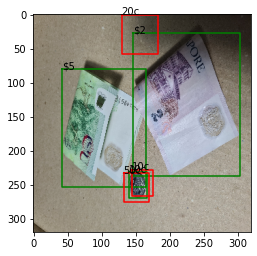

In [212]:
from PIL import Image

def display_img_bbox(img, gt_bboxes, predictions=()):
    '''
    ...
    '''
    plt.imshow(transforms.ToPILImage()(img))
    gt_bbox_color = 'g'
    pred_color = 'r'
    fs = 10

    # plot gt_boxes
    for bbox in gt_bboxes:
        w,h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        x,y = bbox[0], bbox[1]
        x = [x, x + w, x + w, x, x]
        y = [y, y, y + h, y + h, y]
        label_idx = bbox[4].item()
        label = index_label_dict[label_idx]
        plt.text(x[0], y[0], label, fontsize=fs)
        plt.plot(x,y, color = gt_bbox_color, label = label)
    
    # plot predicted boxes
    for bbox in predictions:
        w,h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        x,y = bbox[0], bbox[1]
        x = [x, x + w, x + w, x, x]
        y = [y, y, y + h, y + h, y]
        label = index_label_dict[bbox[4]]
        plt.text(x[0], y[0], label, fontsize=fs)
        plt.plot(x,y, color = pred_color, label = label)

def display_predictions(img, gt_bbox, max_per_image=5, limit_by_objs=True):
    img = img.to(device)
    with torch.no_grad():
        cls_score, cls_pred, cls_prob, bbox_pred, rois = net(img, None, train_flag=False)
        print(cls_score)
        print(cls_pred)
        print(cls_prob)
        print(bbox_pred)
        print(rois)
        boxes = rois[:, 1:5]
        scores = cls_prob
        box_deltas = bbox_pred
        n_objects = len(gt_bbox[0]) if limit_by_objs else 8
        boxes = transform_delta_to_bbox(boxes, box_deltas)
        boxes = clip_boxes(boxes, [320,320])
        predictions, _ = filter_predictions(scores.cpu(), boxes.cpu(), 0.4, 0)
        img = img.view(-1, 320, 320)
        predictions = {label: bboxes[:1] for label, bboxes in predictions.items()}
        predicted_boxes = []
        for label, bboxes in predictions.items():
            for bbox in bboxes:
                bbox_list = bbox.tolist()
                bbox_list.insert(4, label_index_dict[label])
                predicted_boxes.append(bbox_list)
        top_n_predicted_boxes = sorted(predicted_boxes, key=lambda x: x[4])[:n_objects]
        display_img_bbox(img, gt_bbox[0], top_n_predicted_boxes)

net = torch.load('model')
device = torch.device('cuda')
net.to(device)
img, bbox = iter(test_dataloader).next()
display_predictions(img, bbox)